<font color="#483D8B">
<h1  align="center"> Jupyter Notebook</h1>
<div align="center">
<font size=3><b>
<br>Recognizing Emotion in Speech With Neural Networks
<br>Tony Zeng
<br>November 17, 2019
<br></font></b></div>

# Overview
Human emotions can be found through our daily speech. If we are angry, someone might raise their voice. If someone is sad, you might hear abrupt speech patterns. This project will look into audio files from both a male and female to predict such emotions such as happy, sad, angry, etc. 
<br/>
<br/>

There are some major obstacles with speech emotion recognition:
* Emotions are subjective, people would interpret it differently. It is hard to define the notion of emotions.
* Annotating an audio recording is challenging. Should we label a single word, sentence or a whole conversation? How many emotions should we define to recognize?
* Collecting data is complex. There are lots of audio data can be achieved from films or news. However, both of them are biased since news reporting has to be neutral and actors’ emotions are imitated. It is hard to look for neutral audio recording without any bias.
* Labeling data require high human and time cost. Unlike drawing a bounding box on an image, it requires trained personnel to listen to the whole audio recording, analysis it and give an annotation. The annotation result has to be evaluated by multiple individuals due to its subjectivity.

Definitions:
* Mel Frequency Cepstral Coefficient (MFCC): The Mel scale relates perceived frequency, or pitch, of a pure tone to its actual measured frequency. 

References:
* https://towardsdatascience.com/speech-emotion-recognition-with-convolution-neural-network-1e6bb7130ce3
* http://practicalcryptography.com/miscellaneous/machine-learning/guide-mel-frequency-cepstral-coefficients-mfccs/
* https://github.com/MITESHPUTHRANNEU/Speech-Emotion-Analyzer
* https://github.com/marcogdepinto/Emotion-Classification-Ravdess/blob/master/EmotionsRecognition.ipynb

# Data

The data we will be using for this is the Ryerson Audio-Visual Database of Emotional Speech and Song (RAVDESS). The database contains 24 professional actors (12 female, 12 male) vocalizing two lexically-matched statements in a neutral North American accent. Speech includes calm, happy, sad, angry, fearful, surprise, and disgust expressions, and song contains calm, happy, sad, angry, and fearful emotions. Each expression is produced at two levels of emotional intensity (normal, strong), with an additional neutral expression.
<br/>

#### File naming convention
Each of the 7356 RAVDESS files has a unique filename. The filename consists of a 7-part numerical identifier (e.g., 02-01-06-01-02-01-12.mp4). These identifiers define the stimulus characteristics: 
* Modality (01 = full-AV, 02 = video-only, 03 = audio-only).
* Vocal channel (01 = speech, 02 = song).
* Emotion (01 = neutral, 02 = calm, 03 = happy, 04 = sad, 05 = angry, 06 = fearful, 07 = disgust, 08 = surprised).
* Emotional intensity (01 = normal, 02 = strong). NOTE: There is no strong intensity for the 'neutral' emotion.
* Statement (01 = "Kids are talking by the door", 02 = "Dogs are sitting by the door").
* Repetition (01 = 1st repetition, 02 = 2nd repetition).
* Actor (01 to 24. Odd numbered actors are male, even numbered actors are female).

#### Emotions
In this database, we will be looking at a couple of different emotions, this includes:
* Neutral (Not in song version of data)
* Calm
* Happy
* Sad
* Angry
* Fearful
* Disgust (Not in song version of data)
* Surprised (Not in song version of data)


To get the data, go to : https://zenodo.org/record/1188976#.XcuWi1dKiUl The total size of the database is 24.8 GB and contains 7356 files.

In [1]:
#Imports
import librosa
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
from tensorflow import keras
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding
from tensorflow.keras.layers import LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Flatten, Dropout, Activation
from tensorflow.keras.layers import Conv1D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.metrics import confusion_matrix

# Exploratory Data Analysis

In [2]:
#Take a look at one of the audio files
data, sampling_rate = librosa.load(r'C:\Users\tzeng\Documents\INET 4061\INET-4061-Project\ravdess\Actor_01\03-02-01-01-01-01-01.wav')

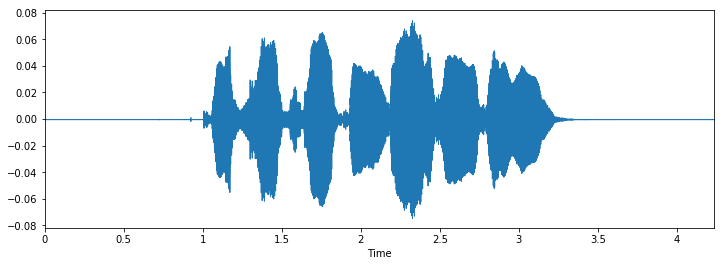

In [3]:
%matplotlib inline
import os
import pandas as pd
import glob

plt.figure(figsize=(12, 4))
librosa.display.waveplot(data, sr=sampling_rate)

C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)
C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log


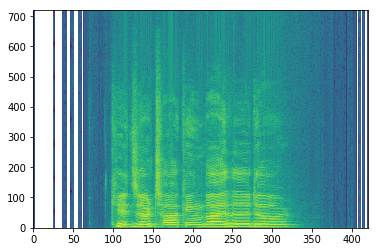

In [4]:
import matplotlib.pyplot as plt
import scipy.io.wavfile
import numpy as np
import sys

sr,x = scipy.io.wavfile.read('ravdess/Actor_01/03-02-01-01-01-01-01.wav')

## Parameters: 10ms step, 30ms window
nstep = int(sr * 0.01)
nwin  = int(sr * 0.03)
nfft = nwin

window = np.hamming(nwin)

## will take windows x[n1:n2].  generate
## and loop over n2 such that all frames
## fit within the waveform
nn = range(nwin, len(x), nstep)

X = np.zeros( (len(nn), nfft//2) )

for i,n in enumerate(nn):
    xseg = x[n-nwin:n]
    z = np.fft.fft(window * xseg, nfft)
    X[i,:] = np.log(np.abs(z[:nfft//2]))

plt.imshow(X.T, interpolation='nearest',
    origin='lower',
    aspect='auto')

plt.show()

In [15]:
import time

path = 'ravdess/'
feeling_list = []

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        if file[6:-16] == '02' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_calm')
        elif file[6:-16] == '02' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_calm')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_happy')
        elif file[6:-16] == '03' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_happy')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_sad')
        elif file[6:-16] == '04' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_sad')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_angry')
        elif file[6:-16] == '05' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_angry')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 0:
            feeling_list.append('female_fearful')
        elif file[6:-16] == '06' and int(file[18:-4]) % 2 == 1:
            feeling_list.append('male_fearful')
        elif file[:1] == 'a':
            feeling_list.append('male_angry')
        elif file[:1] == 'f':
            feeling_list.append('male_fearful')
        elif file[:1] == 'h':
            feeling_list.append('male_happy')
        elif file[:2] == 'sa':
            feeling_list.append('male_sad')

print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 0.17123770713806152 seconds ---


In [16]:
#Verify that mfccs were populated in the list
print(feeling_list)

['male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_calm', 'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_happy', 'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_sad', 'male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_angry', 'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful', 'male_fearful', 'female_calm', 'female_calm', 'female_calm', 'female_calm', 'female_calm', 'female_calm', 'female_calm', 'female_calm', 'female_happy', 'female_happy', 'female_happy', 'female_happy', 'female_happy', 'female_happy', 'female_happy', 'female_happy', 'female_sad', 'female_sad', 'female_sad', 'female_sad', 'female_sad', 'female_sad', 'female_sad', 'female_sad', 'female_angry', 'female_angry', 'female_angry', 'female_angry', 'female_angry', 'female

In [17]:
labels = pd.DataFrame(feeling_list)

In [20]:
labels.head()

,0
0,male_calm
1,male_calm
2,male_calm
3,male_calm
4,male_calm


In [26]:
df = pd.DataFrame(columns=['feature'])
bookmark=0

path = 'ravdess/'

start_time = time.time()

for subdir, dirs, files in os.walk(path):
    for file in files:
        try:
            if file[6:-16]!='01' and file[6:-16]!='07' and file[6:-16]!='08' and file[:2]!='su' and file[:1]!='n' and file[:1]!='d':
                X, sample_rate = librosa.load(os.path.join(subdir,file), res_type='kaiser_fast',duration=2.5,sr=22050*2,offset=0.5)
                sample_rate = np.array(sample_rate)
                mfccs = np.mean(librosa.feature.mfcc(y=X, 
                                                    sr=sample_rate, 
                                                    n_mfcc=13), axis=0)
                feature = mfccs
                df.loc[bookmark] = [feature]
                bookmark=bookmark+1
        except ValueError:
            continue
            
print("--- Data loaded. Loading time: %s seconds ---" % (time.time() - start_time))

--- Data loaded. Loading time: 75.47194170951843 seconds ---


In [27]:
df[:5]

,feature
0,"[-61.542942, -61.670296, -61.663513, -61.67559..."
1,"[-60.61303, -60.61303, -60.61303, -60.61303, -..."
2,"[-61.929478, -61.929478, -61.929478, -61.92947..."
3,"[-59.151585, -59.151585, -59.151585, -59.15158..."
4,"[-65.0231, -65.0231, -65.0231, -65.0231, -65.0..."


In [28]:
df3 = pd.DataFrame(df['feature'].values.tolist())

In [29]:
df3[:5]

,0,1,2,3,4,5,6,7,8,9,...,206,207,208,209,210,211,212,213,214,215
0,-61.542942,-61.670296,-61.663513,-61.675594,-59.627468,-58.578270,-60.384651,-60.370808,-59.209068,-59.793674,...,-28.921122,-32.029648,-28.536741,-27.502647,-26.418861,-27.831207,-28.752033,-28.786448,-21.615858,-17.308699
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-26.426582,-24.405365,-23.668781,-26.999542,-31.112379,-29.247231,-25.843218,-25.077202,-26.445538,-23.854166
2,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394730,-61.859245,-61.559097,-61.015484,-59.214943,...,-26.654114,-29.230816,-31.035513,-30.716604,-32.136162,-31.681684,-30.169340,-28.785442,-21.420412,-17.509743
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-31.761593,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-26.300121,-25.822012,-26.811405,-28.635292,-30.002089,-32.346748,-34.095303,-34.079765,-23.301119,-17.947981


In [30]:
newdf = pd.concat([df3, labels], axis=1)

In [31]:
rnewdf = newdf.rename(index=str, columns={"0":"label"})
rnewdf[:5]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
0,-61.542942,-61.670296,-61.663513,-61.675594,-59.627468,-58.578270,-60.384651,-60.370808,-59.209068,-59.793674,...,-32.029648,-28.536741,-27.502647,-26.418861,-27.831207,-28.752033,-28.786448,-21.615858,-17.308699,male_calm
1,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,-60.613029,...,-24.405365,-23.668781,-26.999542,-31.112379,-29.247231,-25.843218,-25.077202,-26.445538,-23.854166,male_calm
2,-61.929478,-61.929478,-61.929478,-61.929478,-60.674362,-60.394730,-61.859245,-61.559097,-61.015484,-59.214943,...,-29.230816,-31.035513,-30.716604,-32.136162,-31.681684,-30.169340,-28.785442,-21.420412,-17.509743,male_calm
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303,male_calm
4,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,-65.023102,...,-25.822012,-26.811405,-28.635292,-30.002089,-32.346748,-34.095303,-34.079765,-23.301119,-17.947981,male_calm


In [32]:
from sklearn.utils import shuffle
rnewdf = shuffle(newdf)
rnewdf[:10]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
286,-58.811028,-57.387314,-54.101215,-53.484745,-53.376385,-55.020466,-55.381741,-54.714958,-53.905636,-54.861187,...,-37.502090,-38.006714,-39.590340,-39.118992,-38.932175,-39.303505,-38.988667,-21.919701,-14.153309,female_calm
125,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,-58.149353,...,-41.910679,-44.171371,-43.805035,-43.253147,-41.964558,-38.993343,-38.353531,-34.762352,-28.635719,female_calm
236,-51.098198,-50.970638,-49.467705,-48.758865,-48.571693,-47.207027,-45.486557,-44.088036,-41.911274,-41.947086,...,-43.104149,-42.438641,-41.788998,-41.241093,-42.062130,-41.408592,-40.816708,-20.383068,-11.797126,female_fearful
523,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,-66.232719,...,-35.934635,-35.911716,-42.350136,-45.598446,-43.940430,-42.481136,-42.885498,-31.850229,-23.748720,female_calm
40,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,-59.344055,...,-42.964806,-43.955097,-44.208004,-43.749870,-42.165379,-43.236347,-43.611912,-20.658558,-12.422130,female_calm
314,-53.781651,-53.352600,-53.589684,-54.727432,-55.393063,-55.169559,-53.168503,-53.740688,-53.981636,-50.686012,...,-43.582493,-43.651901,-42.388069,-41.603786,-41.811924,-41.113071,-42.656906,-35.905605,-29.330324,female_fearful
904,-54.369865,-54.369865,-54.369865,-54.369865,-54.369865,-54.465820,-54.586063,-54.691383,-54.763992,-55.405582,...,-46.245510,-44.874165,-43.632973,-43.716179,-46.610348,-44.998837,-41.841633,-23.601112,-14.957533,female_angry
655,-46.986485,-46.792435,-46.612442,-46.630112,-45.646877,-46.305893,-47.200603,-46.614082,-47.392818,-47.315750,...,-19.993809,-19.173664,-19.085762,-20.418121,-19.544733,-20.263161,-20.613770,-10.640030,-5.008472,male_happy
822,-51.952774,-51.486469,-52.428757,-50.519428,-48.061848,-48.072117,-49.395264,-50.069740,-50.161179,-48.364712,...,-42.099064,-42.196964,-40.745102,-39.797340,-40.512894,-41.566936,-42.393772,-28.078463,-21.023251,female_sad
762,-51.187954,-50.650723,-51.760902,-53.021000,-55.392570,-55.491417,-54.203873,-53.655472,-52.914307,-52.938232,...,-24.372551,-24.297350,-23.960182,-24.023012,-23.947481,-24.435537,-23.883450,-12.978514,-7.976301,male_calm


In [33]:
rnewdf = rnewdf.fillna(0)

### Divide the data into test and train

In [34]:
newdf1 = np.random.rand(len(rnewdf)) < 0.8
train = rnewdf[newdf1]
test = rnewdf[~newdf1]

In [35]:
train[250:260]

,0,1,2,3,4,5,6,7,8,9,...,207,208,209,210,211,212,213,214,215,0
14,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,-51.556450,...,-24.600010,-24.786633,-24.616468,-24.369358,-24.294329,-24.317953,-24.839272,-22.316542,-19.167992,male_happy
691,-55.604935,-55.636604,-56.766270,-54.728760,-54.332371,-53.939491,-53.025993,-52.874660,-53.887455,-55.134098,...,-26.218998,-26.019176,-25.813856,-28.464924,-31.025351,-29.192289,-29.069883,-31.586348,-30.823273,male_happy
215,-47.647747,-46.622139,-47.108501,-49.672264,-49.012329,-47.569328,-50.093361,-48.178013,-47.952232,-48.381695,...,-46.218040,-45.786736,-47.132286,-47.077274,-46.852695,-44.209286,-43.528671,-37.750351,-29.891960,female_happy
136,-60.602760,-60.924973,-61.564846,-58.466652,-56.777580,-58.518856,-60.507912,-60.939365,-61.327934,-62.278904,...,-47.085533,-45.905193,-45.820110,-45.183754,-45.501438,-43.343262,-43.069851,-42.566330,-36.447308,female_sad
35,-53.351719,-53.480797,-53.647358,-52.728451,-52.508938,-51.377071,-53.504299,-53.810806,-54.757404,-53.981930,...,-30.114628,-33.561642,-34.265484,-31.826622,-31.536583,-33.563114,-33.078178,-20.716511,-14.410389,male_fearful
499,-54.408718,-53.039444,-55.203388,-59.015152,-58.867477,-59.455349,-59.350174,-58.846439,-58.235588,-57.366684,...,-30.479206,-31.284288,-30.414249,-30.573662,-31.867998,-32.529099,-33.849579,-28.472582,-23.672495,male_sad
550,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,-49.561157,...,-39.505741,-39.110931,-39.935795,-36.449863,-34.972511,-37.891800,-37.415047,-31.468679,-25.149483,female_angry
253,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,-59.455784,...,-23.726042,-22.780537,-25.077789,-26.348011,-27.579496,-27.656370,-27.729753,-22.199360,-18.074202,male_happy
436,-53.375668,-53.904781,-53.140434,-53.550789,-53.028118,-51.710667,-50.552860,-50.813190,-53.487061,-53.608559,...,-36.383446,-35.522125,-36.603279,-38.208889,-39.881252,-40.991249,-42.293659,-43.540085,-40.204567,male_fearful
3,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.151585,-59.149441,-58.931152,...,-32.370949,-31.170330,-28.492159,-26.996380,-26.160204,-26.592115,-27.137033,-21.495012,-16.727303,male_calm


In [37]:
trainfeatures = train.iloc[:, :-1]
trainlabel = train.iloc[:, -1:]
testfeatures = test.iloc[:, :-1]
testlabel = test.iloc[:, -1:]

In [42]:
from tensorflow.python.keras import utils
from sklearn.preprocessing import LabelEncoder

X_train = np.array(trainfeatures)
y_train = np.array(trainlabel)
X_test = np.array(testfeatures)
y_test = np.array(testlabel)

lb = LabelEncoder()

y_train = utils.to_categorical(lb.fit_transform(y_train))
y_test = utils.to_categorical(lb.fit_transform(y_test))

C:\Users\tzeng\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\preprocessing\label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [43]:
y_train

array([[0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.]], dtype=float32)

In [44]:
X_train.shape

(734, 216)

# Model

# Conclusion